# Training ANN model on data

    Find best size for test set

In [1]:
!pip install pandas
!pip install sklearn

import pandas as pd;
import numpy as np;
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict;
from sklearn.preprocessing import MinMaxScaler;
from sklearn import metrics;
from sklearn.model_selection import TimeSeriesSplit;

import keras
from keras.models import Sequential # to initialise the NN
from keras.layers import Dense # to create layers
from keras.layers import Dropout
from keras import initializers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

mae_cv = []
mse_cv = []
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []

In [8]:
test_set_range = [0.108, 0.116, 0.124, 0.132, 0.140, 0.148, 0.156, 0.164, 0.172]
a = 0.172

#for i in a:
    # import data
data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

    # 2018 data
data = data.loc[data.index > 2018100000, :]

    # reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

    # Divide features and labels
X = data.iloc[:, 0:15]
y = data.loc[:, 'Offers']
    
X.fillna(method = 'ffill', inplace = True)
y.fillna(method = 'ffill', inplace = True)

X = X.round(20)
    
    # divide data into train and test with 10% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.172, shuffle=False)

    # feature scaling
sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
    
def regressor_tunning(n_hidden = 5, 
                      n_neurons = 40, 
                      kernel_initializer = "he_normal",
                      bias_initializer = initializers.Ones()):
    model = Sequential()
    model.add(Dense(units = n_neurons, input_dim = 15))
    model.add(keras.layers.LeakyReLU(alpha = 0.2))
    model.add(Dropout(rate = 0.1))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons))
        model.add(keras.layers.LeakyReLU(alpha = 0.2))
        model.add(Dropout(rate = 0.1))
    model.add(Dense(units = 1, activation = 'linear'))
    optimizer = optimizers.Adamax(lr = 0.001)
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse', 'mae'])
    return model

tscv = TimeSeriesSplit(n_splits = 10)
hist_list = pd.DataFrame()
count = 1
    
regressor = regressor_tunning()
    
for train_index, test_index in tscv.split(X_train):
    X_train_split, X_test_split = X_train[train_index], X_train[test_index]
    y_train_split, y_test_split = y_train[train_index], y_train[test_index]
    hist = regressor.fit(X_train_split, y_train_split, batch_size = 15, epochs = 100)
    hist_list = hist_list.append(hist.history, ignore_index = True)
    print(count)
    count = count + 1

a = []
b = []
    
for i in range(len(hist_list.mse)):
    a.append(np.mean(hist_list.mse[i]))
    b.append(np.mean(hist_list.mae[i]))
      
mse_cv.append(np.mean(a))
mae_cv.append(np.mean(b))
    
    # predict for X_test  
y_pred = regressor.predict(X_test)

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

rmse_error = mse(y_test, y_pred, squared = False)
mse_error = mse(y_test, y_pred) # 1479.61335
mae_error = mae(y_test, y_pred) # 23.1525
    
rmse_gen.append(rmse_error)
mse_gen.append(mse_error)
mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
# create array same size as y_test
y_spike_occ = y_spike_occ.iloc[- len(y_test):]
y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    
# smal adjustment
y_test.replace(0, 0.0001,inplace = True)

    
# select y_pred and y_test only for regions with spikes
y_test_spike = (y_test.T * y_spike_occ).T
y_pred_spike = (y_pred.T * y_spike_occ).T
y_test_spike = y_test_spike[y_test_spike != 0]
y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
# calculate metric
rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
mse_spike = mse(y_test_spike, y_pred_spike)
mae_spike = mae(y_test_spike, y_pred_spike)
    
rmse_spi.append(rmse_spike)
mse_spi.append(mse_spike)
mae_spi.append(mae_spike)
    
# =============================================================================
# Metric evaluation on normal regions
# =============================================================================
    
# inverse y_spike_occ so the only normal occurences are chosen
y_normal_occ = (y_spike_occ - 1) * (-1)
    
# sanity check
y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
# select y_pred and y_test only for normal regions
y_test_normal = (y_test.T * y_normal_occ).T
y_pred_normal = (y_pred.T * y_normal_occ).T
y_test_normal = y_test_normal[y_test_normal != 0.00]
y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
# calculate metric
rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
mse_normal = mse(y_test_normal, y_pred_normal)
mae_normal = mae(y_test_normal, y_pred_normal)
    
rmse_nor.append(rmse_normal)
mse_nor.append(mse_normal)
mae_nor.append(mae_normal)


Epoch 1/100
23/23 [==============================] - 0s 1ms/step - loss: 14133.7295 - mse: 14133.7295 - mae: 113.2800
Epoch 2/100
23/23 [==============================] - 0s 1ms/step - loss: 13814.3428 - mse: 13814.3428 - mae: 111.8529
Epoch 3/100
23/23 [==============================] - 0s 1ms/step - loss: 12750.7520 - mse: 12750.7520 - mae: 107.0155
Epoch 4/100
23/23 [==============================] - 0s 1ms/step - loss: 9623.0488 - mse: 9623.0488 - mae: 90.5153
Epoch 5/100
23/23 [==============================] - 0s 1ms/step - loss: 3539.7422 - mse: 3539.7422 - mae: 44.7294
Epoch 6/100
23/23 [==============================] - 0s 1ms/step - loss: 2099.1707 - mse: 2099.1707 - mae: 32.1651
Epoch 7/100
23/23 [==============================] - 0s 1ms/step - loss: 1988.1444 - mse: 1988.1444 - mae: 30.5262
Epoch 8/100
23/23 [==============================] - 0s 1ms/step - loss: 1859.2949 - mse: 1859.2949 - mae: 30.1184
Epoch 9/100
23/23 [==============================] - 0s 1ms/step - loss

23/23 [==============================] - 0s 1ms/step - loss: 1404.2585 - mse: 1404.2585 - mae: 25.3616
Epoch 72/100
23/23 [==============================] - 0s 1ms/step - loss: 1445.7460 - mse: 1445.7460 - mae: 25.3537
Epoch 73/100
23/23 [==============================] - 0s 1ms/step - loss: 1320.5481 - mse: 1320.5481 - mae: 25.1312
Epoch 74/100
23/23 [==============================] - 0s 1ms/step - loss: 1529.5530 - mse: 1529.5530 - mae: 26.0048
Epoch 75/100
23/23 [==============================] - 0s 1ms/step - loss: 1460.2943 - mse: 1460.2943 - mae: 24.9630
Epoch 76/100
23/23 [==============================] - 0s 1ms/step - loss: 1431.3459 - mse: 1431.3459 - mae: 26.2177
Epoch 77/100
23/23 [==============================] - 0s 1ms/step - loss: 1538.3954 - mse: 1538.3954 - mae: 26.8488
Epoch 78/100
23/23 [==============================] - 0s 2ms/step - loss: 1499.0012 - mse: 1499.0012 - mae: 26.2679
Epoch 79/100
23/23 [==============================] - 0s 2ms/step - loss: 1529.7136 -

45/45 [==============================] - 0s 754us/step - loss: 1549.8566 - mse: 1549.8567 - mae: 27.0730
Epoch 42/100
45/45 [==============================] - 0s 754us/step - loss: 1462.8220 - mse: 1462.8220 - mae: 26.0869
Epoch 43/100
45/45 [==============================] - 0s 820us/step - loss: 1473.1118 - mse: 1473.1118 - mae: 26.4987
Epoch 44/100
45/45 [==============================] - 0s 820us/step - loss: 1609.0204 - mse: 1609.0204 - mae: 27.2754
Epoch 45/100
45/45 [==============================] - 0s 798us/step - loss: 1495.6014 - mse: 1495.6014 - mae: 26.5429
Epoch 46/100
45/45 [==============================] - 0s 810us/step - loss: 1531.3584 - mse: 1531.3585 - mae: 26.5061
Epoch 47/100
45/45 [==============================] - 0s 776us/step - loss: 1637.0077 - mse: 1637.0077 - mae: 27.4456
Epoch 48/100
45/45 [==============================] - 0s 776us/step - loss: 1453.8395 - mse: 1453.8395 - mae: 26.0045
Epoch 49/100
45/45 [==============================] - 0s 754us/step -

67/67 [==============================] - 0s 774us/step - loss: 1345.6545 - mse: 1345.6545 - mae: 25.0338
Epoch 11/100
67/67 [==============================] - 0s 789us/step - loss: 1355.0468 - mse: 1355.0468 - mae: 24.5447
Epoch 12/100
67/67 [==============================] - 0s 819us/step - loss: 1307.3513 - mse: 1307.3513 - mae: 25.4417
Epoch 13/100
67/67 [==============================] - 0s 848us/step - loss: 1366.6273 - mse: 1366.6273 - mae: 25.2421
Epoch 14/100
67/67 [==============================] - 0s 819us/step - loss: 1369.8059 - mse: 1369.8059 - mae: 25.3827
Epoch 15/100
67/67 [==============================] - 0s 804us/step - loss: 1368.5438 - mse: 1368.5438 - mae: 25.2277
Epoch 16/100
67/67 [==============================] - 0s 759us/step - loss: 1333.9841 - mse: 1333.9841 - mae: 24.8836
Epoch 17/100
67/67 [==============================] - 0s 804us/step - loss: 1307.9594 - mse: 1307.9594 - mae: 24.4930
Epoch 18/100
67/67 [==============================] - 0s 1ms/step - l

Epoch 80/100
67/67 [==============================] - 0s 819us/step - loss: 1295.5239 - mse: 1295.5239 - mae: 24.5081
Epoch 81/100
67/67 [==============================] - 0s 1ms/step - loss: 1257.6859 - mse: 1257.6859 - mae: 24.2672
Epoch 82/100
67/67 [==============================] - 0s 1ms/step - loss: 1262.9717 - mse: 1262.9717 - mae: 24.3512
Epoch 83/100
67/67 [==============================] - 0s 1ms/step - loss: 1307.9193 - mse: 1307.9193 - mae: 24.9136
Epoch 84/100
67/67 [==============================] - 0s 985us/step - loss: 1308.5518 - mse: 1308.5518 - mae: 24.5660
Epoch 85/100
67/67 [==============================] - 0s 1ms/step - loss: 1269.9672 - mse: 1269.9672 - mae: 24.4131
Epoch 86/100
67/67 [==============================] - 0s 1ms/step - loss: 1245.5638 - mse: 1245.5638 - mae: 24.0872
Epoch 87/100
67/67 [==============================] - 0s 2ms/step - loss: 1316.0544 - mse: 1316.0544 - mae: 25.2568
Epoch 88/100
67/67 [==============================] - 0s 1ms/step - 

89/89 [==============================] - 0s 812us/step - loss: 1254.5847 - mse: 1254.5847 - mae: 24.5321
Epoch 50/100
89/89 [==============================] - 0s 818us/step - loss: 1193.0978 - mse: 1193.0978 - mae: 24.1260
Epoch 51/100
89/89 [==============================] - 0s 808us/step - loss: 1238.5040 - mse: 1238.5040 - mae: 23.9872
Epoch 52/100
89/89 [==============================] - 0s 868us/step - loss: 1235.3290 - mse: 1235.3290 - mae: 24.5002
Epoch 53/100
89/89 [==============================] - 0s 927us/step - loss: 1223.4945 - mse: 1223.4945 - mae: 24.2957
Epoch 54/100
89/89 [==============================] - 0s 885us/step - loss: 1221.9103 - mse: 1221.9103 - mae: 24.1720
Epoch 55/100
89/89 [==============================] - 0s 1ms/step - loss: 1198.6584 - mse: 1198.6584 - mae: 24.0783
Epoch 56/100
89/89 [==============================] - 0s 964us/step - loss: 1196.6133 - mse: 1196.6133 - mae: 23.7287
Epoch 57/100
89/89 [==============================] - 0s 1ms/step - los

112/112 [==============================] - 0s 1ms/step - loss: 1297.2086 - mse: 1297.2086 - mae: 25.0519
Epoch 19/100
112/112 [==============================] - 0s 1ms/step - loss: 1316.4497 - mse: 1316.4497 - mae: 25.3722
Epoch 20/100
112/112 [==============================] - 0s 1ms/step - loss: 1310.5042 - mse: 1310.5042 - mae: 25.5619
Epoch 21/100
112/112 [==============================] - 0s 1ms/step - loss: 1280.7386 - mse: 1280.7386 - mae: 25.3015
Epoch 22/100
112/112 [==============================] - 0s 2ms/step - loss: 1280.8723 - mse: 1280.8723 - mae: 24.5223
Epoch 23/100
112/112 [==============================] - 0s 1ms/step - loss: 1304.9004 - mse: 1304.9004 - mae: 25.1976
Epoch 24/100
112/112 [==============================] - 0s 1ms/step - loss: 1344.1578 - mse: 1344.1578 - mae: 25.6459
Epoch 25/100
112/112 [==============================] - 0s 1ms/step - loss: 1327.5192 - mse: 1327.5192 - mae: 25.2779
Epoch 26/100
112/112 [==============================] - 0s 1ms/step -

112/112 [==============================] - 0s 1ms/step - loss: 1247.6091 - mse: 1247.6091 - mae: 24.4144
Epoch 88/100
112/112 [==============================] - 0s 1ms/step - loss: 1282.7723 - mse: 1282.7723 - mae: 24.9467
Epoch 89/100
112/112 [==============================] - 0s 1ms/step - loss: 1216.8594 - mse: 1216.8594 - mae: 24.4264
Epoch 90/100
112/112 [==============================] - 0s 1ms/step - loss: 1268.9132 - mse: 1268.9132 - mae: 24.8462
Epoch 91/100
112/112 [==============================] - 0s 1ms/step - loss: 1266.7386 - mse: 1266.7386 - mae: 24.9039
Epoch 92/100
112/112 [==============================] - 0s 1ms/step - loss: 1281.6084 - mse: 1281.6084 - mae: 24.8616
Epoch 93/100
112/112 [==============================] - 0s 1ms/step - loss: 1240.8080 - mse: 1240.8080 - mae: 24.2939
Epoch 94/100
112/112 [==============================] - 0s 1ms/step - loss: 1220.5920 - mse: 1220.5920 - mae: 24.2259
Epoch 95/100
112/112 [==============================] - 0s 1ms/step -

134/134 [==============================] - 0s 961us/step - loss: 2177.9246 - mse: 2177.9246 - mae: 24.9320
Epoch 57/100
134/134 [==============================] - 0s 1ms/step - loss: 2176.2722 - mse: 2176.2722 - mae: 24.9454
Epoch 58/100
134/134 [==============================] - 0s 1ms/step - loss: 2225.5410 - mse: 2225.5410 - mae: 25.2523
Epoch 59/100
134/134 [==============================] - 0s 1ms/step - loss: 2123.5579 - mse: 2123.5579 - mae: 24.7551
Epoch 60/100
134/134 [==============================] - 0s 1ms/step - loss: 2205.2812 - mse: 2205.2812 - mae: 24.7395
Epoch 61/100
134/134 [==============================] - 0s 1ms/step - loss: 2176.5305 - mse: 2176.5305 - mae: 24.9319
Epoch 62/100
134/134 [==============================] - 0s 987us/step - loss: 2192.8943 - mse: 2192.8943 - mae: 25.0148
Epoch 63/100
134/134 [==============================] - 0s 1ms/step - loss: 2155.0874 - mse: 2155.0874 - mae: 24.3423
Epoch 64/100
134/134 [==============================] - 0s 2ms/st

Epoch 25/100
156/156 [==============================] - 0s 2ms/step - loss: 2033.1379 - mse: 2033.1379 - mae: 24.4443
Epoch 26/100
156/156 [==============================] - 0s 1ms/step - loss: 2034.4648 - mse: 2034.4646 - mae: 24.2871
Epoch 27/100
156/156 [==============================] - 0s 2ms/step - loss: 2022.5758 - mse: 2022.5758 - mae: 24.3751
Epoch 28/100
156/156 [==============================] - 0s 2ms/step - loss: 2020.3998 - mse: 2020.3998 - mae: 24.3224
Epoch 29/100
156/156 [==============================] - 0s 1ms/step - loss: 1993.9150 - mse: 1993.9150 - mae: 24.2438
Epoch 30/100
156/156 [==============================] - 0s 1ms/step - loss: 2003.1982 - mse: 2003.1982 - mae: 24.3050
Epoch 31/100
156/156 [==============================] - 0s 1ms/step - loss: 2019.2301 - mse: 2019.2301 - mae: 24.3436
Epoch 32/100
156/156 [==============================] - 0s 2ms/step - loss: 2020.7505 - mse: 2020.7505 - mae: 24.4975
Epoch 33/100
156/156 [==============================] - 

156/156 [==============================] - 0s 1ms/step - loss: 2004.6783 - mse: 2004.6783 - mae: 24.4507
Epoch 95/100
156/156 [==============================] - 0s 1ms/step - loss: 2000.4893 - mse: 2000.4893 - mae: 24.3640
Epoch 96/100
156/156 [==============================] - 0s 1ms/step - loss: 2027.5210 - mse: 2027.5210 - mae: 24.3600
Epoch 97/100
156/156 [==============================] - 0s 1ms/step - loss: 2007.4934 - mse: 2007.4934 - mae: 24.0999
Epoch 98/100
156/156 [==============================] - 0s 1ms/step - loss: 1981.2069 - mse: 1981.2069 - mae: 23.9902
Epoch 99/100
156/156 [==============================] - 0s 1ms/step - loss: 1999.2522 - mse: 1999.2522 - mae: 24.4203
Epoch 100/100
156/156 [==============================] - 0s 1ms/step - loss: 1997.2751 - mse: 1997.2751 - mae: 24.4027
7
Epoch 1/100
178/178 [==============================] - 0s 925us/step - loss: 2262.4636 - mse: 2262.4636 - mae: 26.0192
Epoch 2/100
178/178 [==============================] - 0s 897us/s

178/178 [==============================] - 0s 1ms/step - loss: 2162.0999 - mse: 2162.0999 - mae: 25.2211
Epoch 64/100
178/178 [==============================] - 0s 1ms/step - loss: 2191.9973 - mse: 2191.9973 - mae: 25.4824
Epoch 65/100
178/178 [==============================] - 0s 1ms/step - loss: 2218.7896 - mse: 2218.7896 - mae: 25.5785
Epoch 66/100
178/178 [==============================] - 0s 1ms/step - loss: 2175.6968 - mse: 2175.6968 - mae: 25.2864
Epoch 67/100
178/178 [==============================] - 0s 1ms/step - loss: 2158.7446 - mse: 2158.7446 - mae: 25.7156
Epoch 68/100
178/178 [==============================] - 0s 1ms/step - loss: 2198.3865 - mse: 2198.3865 - mae: 25.6839
Epoch 69/100
178/178 [==============================] - 0s 1ms/step - loss: 2162.3789 - mse: 2162.3789 - mae: 25.6082
Epoch 70/100
178/178 [==============================] - 0s 1ms/step - loss: 2187.3191 - mse: 2187.3191 - mae: 25.6352
Epoch 71/100
178/178 [==============================] - 0s 1ms/step -

200/200 [==============================] - 0s 1ms/step - loss: 1943.9666 - mse: 1943.9666 - mae: 24.2988
Epoch 33/100
200/200 [==============================] - 0s 1ms/step - loss: 2014.9360 - mse: 2014.9359 - mae: 24.6762
Epoch 34/100
200/200 [==============================] - 0s 2ms/step - loss: 1949.6042 - mse: 1949.6042 - mae: 24.7372
Epoch 35/100
200/200 [==============================] - 0s 2ms/step - loss: 1920.1412 - mse: 1920.1412 - mae: 24.2350
Epoch 36/100
200/200 [==============================] - 0s 1ms/step - loss: 1953.4841 - mse: 1953.4841 - mae: 24.1560
Epoch 37/100
200/200 [==============================] - 0s 1ms/step - loss: 1975.6555 - mse: 1975.6553 - mae: 24.4764
Epoch 38/100
200/200 [==============================] - 0s 1ms/step - loss: 1988.8923 - mse: 1988.8923 - mae: 24.5549
Epoch 39/100
200/200 [==============================] - 0s 1000us/step - loss: 1939.6342 - mse: 1939.6342 - mae: 24.1565
Epoch 40/100
200/200 [==============================] - 0s 1ms/ste

200/200 [==============================] - 0s 1ms/step - loss: 1892.0739 - mse: 1892.0739 - mae: 24.2161
9
Epoch 1/100
222/222 [==============================] - 0s 1ms/step - loss: 1798.3271 - mse: 1798.3271 - mae: 23.8274
Epoch 2/100
222/222 [==============================] - 0s 1ms/step - loss: 1802.8694 - mse: 1802.8694 - mae: 23.8318
Epoch 3/100
222/222 [==============================] - 0s 1ms/step - loss: 1801.6788 - mse: 1801.6788 - mae: 23.8180
Epoch 4/100
222/222 [==============================] - 0s 1ms/step - loss: 1841.8798 - mse: 1841.8798 - mae: 23.9561
Epoch 5/100
222/222 [==============================] - 0s 1ms/step - loss: 1837.3979 - mse: 1837.3979 - mae: 24.0790
Epoch 6/100
222/222 [==============================] - 0s 1ms/step - loss: 1852.0039 - mse: 1852.0039 - mae: 24.0743
Epoch 7/100
222/222 [==============================] - 0s 1ms/step - loss: 1786.3901 - mse: 1786.3901 - mae: 23.7831
Epoch 8/100
222/222 [==============================] - 0s 962us/step - los

222/222 [==============================] - 0s 1ms/step - loss: 1776.5814 - mse: 1776.5814 - mae: 23.4709
Epoch 70/100
222/222 [==============================] - 0s 1ms/step - loss: 1768.8657 - mse: 1768.8657 - mae: 23.4915
Epoch 71/100
222/222 [==============================] - 0s 1ms/step - loss: 1777.0684 - mse: 1777.0684 - mae: 23.6930
Epoch 72/100
222/222 [==============================] - 0s 1ms/step - loss: 1777.9955 - mse: 1777.9955 - mae: 23.5676
Epoch 73/100
222/222 [==============================] - 0s 1ms/step - loss: 1777.8600 - mse: 1777.8600 - mae: 23.5304
Epoch 74/100
222/222 [==============================] - 0s 1ms/step - loss: 1795.5448 - mse: 1795.5448 - mae: 23.7031
Epoch 75/100
222/222 [==============================] - 0s 1ms/step - loss: 1769.3766 - mse: 1769.3766 - mae: 23.5299
Epoch 76/100
222/222 [==============================] - 0s 1ms/step - loss: 1753.0300 - mse: 1753.0300 - mae: 23.2174: 0s - loss: 2157.6062 - mse: 2157.6062 - mae: 2
Epoch 77/100
222/222 

In [9]:
rmse_gen

[31.527710019165564,
 31.021677364744527,
 31.530537460715415,
 30.161236431171275,
 30.680017349013653,
 30.612857307868445,
 29.735732209621535,
 30.745396123435963,
 30.901487593523246]

In [10]:
rmse_cv = []
for i in mse_cv:
    rmse_cv.append(i ** 0.5)
    
results = pd.DataFrame({'rmse_cv':rmse_cv,
              
                        'mae_cv': mae_cv,
                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor}, index = test_set_range)

results

,rmse_cv,mae_cv,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0.108,41.467388,25.302067,31.527710,22.624532,62.736278,51.082576,21.334101,17.411920
0.116,41.163333,25.033958,31.021677,22.919753,59.361791,48.848137,23.034087,18.549137
0.124,41.261730,24.968676,31.530537,22.911087,62.434138,50.482962,22.147454,18.128813
0.132,41.663638,25.314088,30.161236,21.738691,60.612921,49.236729,21.404981,17.246980
0.140,41.789995,25.463917,30.680017,21.543821,63.793339,51.444203,20.728633,16.654096
0.148,41.750137,25.369146,30.612857,22.343250,61.226289,49.752629,21.838031,17.856305
0.156,41.880669,25.392486,29.735732,20.521309,64.495232,51.794515,19.338363,15.649604
0.164,41.971496,25.464605,30.745396,22.055713,65.685173,52.994781,21.056132,17.446723
0.172,41.869346,25.339919,30.901488,21.854861,65.725588,53.713646,20.815461,16.916265


In [11]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt

In [12]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_cv,mae_cv,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0.108,41.467388,25.302067,31.527710,22.624532,62.736278,51.082576,21.334101,17.411920
0.116,41.163333,25.033958,31.021677,22.919753,59.361791,48.848137,23.034087,18.549137
0.124,41.261730,24.968676,31.530537,22.911087,62.434138,50.482962,22.147454,18.128813
0.132,41.663638,25.314088,30.161236,21.738691,60.612921,49.236729,21.404981,17.246980
0.14,41.789995,25.463917,30.680017,21.543821,63.793339,51.444203,20.728633,16.654096
0.148,41.750137,25.369146,30.612857,22.343250,61.226289,49.752629,21.838031,17.856305
0.156,41.880669,25.392486,29.735732,20.521309,64.495232,51.794515,19.338363,15.649604
0.164,41.971496,25.464605,30.745396,22.055713,65.685173,52.994781,21.056132,17.446723
0.172,41.869346,25.339919,30.901488,21.854861,65.725588,53.713646,20.815461,16.916265


<IPython.core.display.Javascript object>


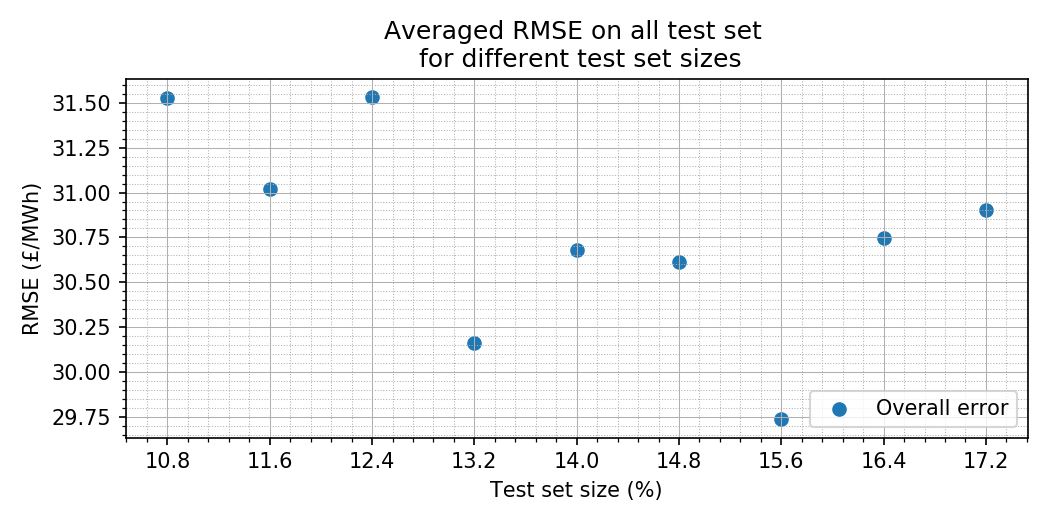

<IPython.core.display.Javascript object>


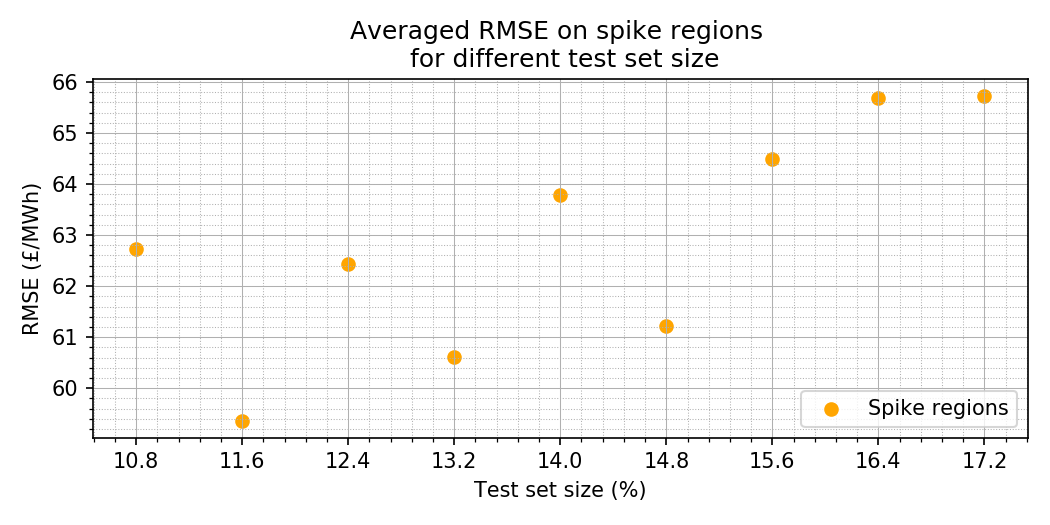

<IPython.core.display.Javascript object>


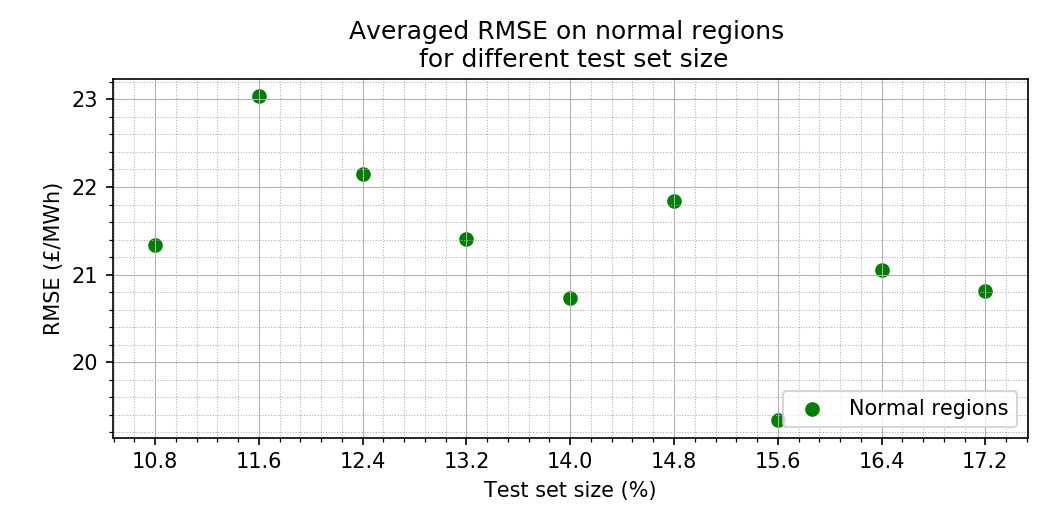

[10.8, 11.6, 12.4, 13.2, 14.0, 14.8, 15.6, 16.4, 17.2]

In [19]:
plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE on all test set \n for different test set sizes')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y = rmse_gen, label = 'Overall error')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(round(i * 100, 2))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('RMSE_detail_best_test_set_all.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE on spike regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y =rmse_spi, label = 'Spike regions', color = 'orange')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(round(i * 100, 2))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('RMSE_detail_best_test_set_spike.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE on normal regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y =rmse_nor, label = 'Normal regions', color = 'green')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(round(i * 100, 2))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('RMSE_detail_best_test_set_normal.png')
a

<IPython.core.display.Javascript object>


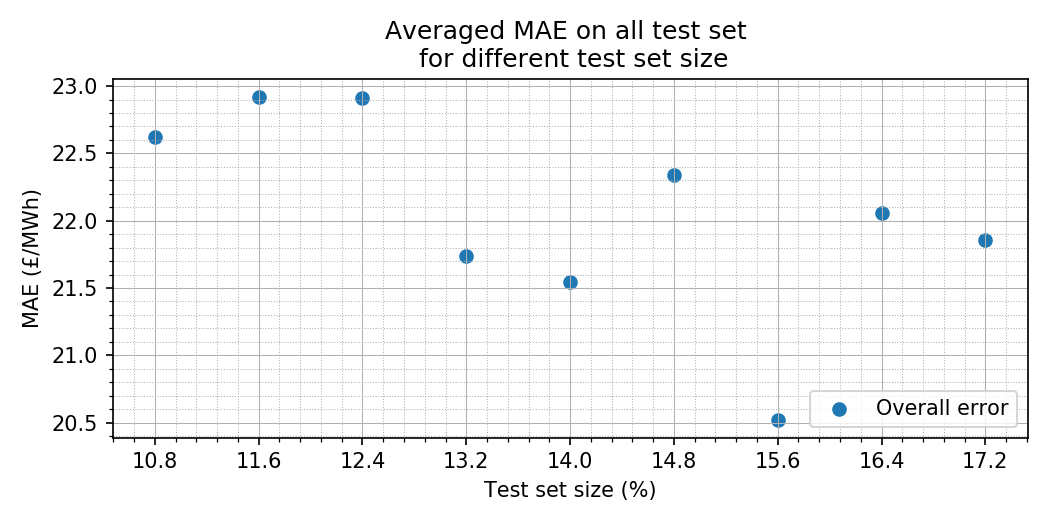

<IPython.core.display.Javascript object>


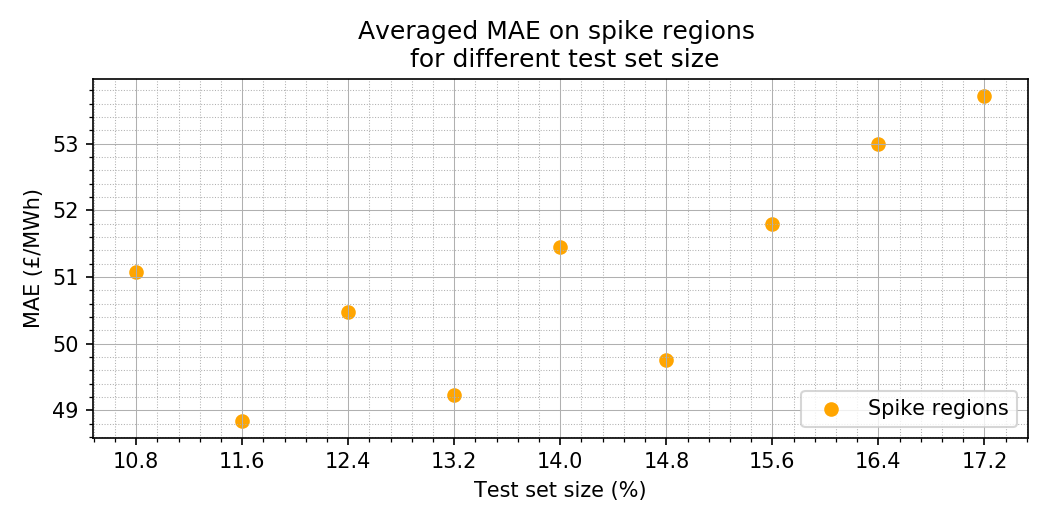

<IPython.core.display.Javascript object>


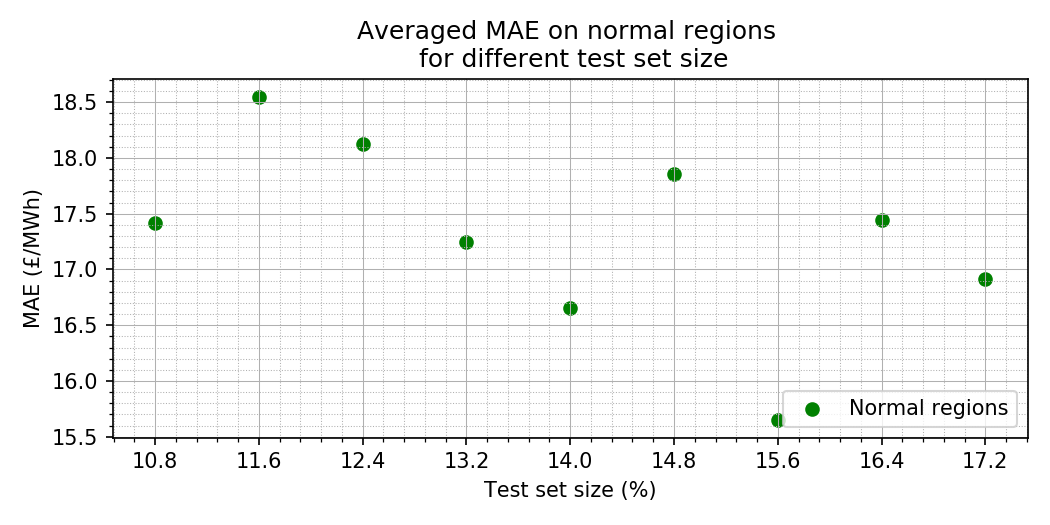

In [20]:
plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged MAE on all test set \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y = mae_gen, label = 'Overall error')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(round(i * 100, 2))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('MAE_detail_best_test_set_normal.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged MAE on spike regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y =mae_spi, label = 'Spike regions', color = 'orange')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(round(i * 100, 2))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('MAE_detail_best_test_set_spike.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged MAE on normal regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y = mae_nor, label = 'Normal regions', color = 'green')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(round(i * 100, 2))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('MAE_detail_best_test_set_normal.png')